# Stock Portfolio Forecasting and Optimization on S&P500

The stock market is known for its volatility and unpredictability, posing significant challenges for investors seeking efficient strategies to maximize returns. This project aims to address these challenges by leveraging machine learning techniques for stock price forecasting and optimization methods for portfolio selection. The ultimate goal is to build an efficient investment strategy based on historical data from the S&P 500, focusing on predicting daily returns and optimizing portfolio composition to maximize cumulative returns.

Given the computational demands of forecasting and optimizing across all companies in the S&P 500, we began our analysis using the SPDR S&P 500 ETF (SPY). The SPY is a widely used exchange-traded fund that tracks the performance of the S&P 500 and serves as a representative proxy for the index. By focusing on SPY, we were able to optimize our models and explore key aspects such as the ideal number of time steps, feature creation, output targets, and model parameters in a computationally feasible manner.

**While optimizing models directly on the SPY provides valuable insights, we acknowledge that a comprehensive analysis across all S&P 500 companies would yield more accurate and generalizable results. However, the SPY serves as an effective starting point for our predictive framework, allowing us to refine methodologies before scaling to the entire index. This iterative approach ensures that our solutions remain practical and adaptable, even within the constraints of limited computational resources.**

## SPY Forecasting

In developing our predictive framework and trading strategy, we drew insights from a variety of academic and practical resources. These included several articles, which are listed in the references at the end of this notebook, providing foundational knowledge and inspiration for our methodologies. Additionally, we referenced three influential books that significantly guided our approach:

- Automation of Trading Machines for Traders by Jacinta Chan: This book provided essential insights into developing trading models and automating trading strategies.

- Technical Analysis Masterclass by Rolf Schlotmann and Moritz Czubatinski: A comprehensive guide on the principles of technical analysis, this book helped refine our understanding of key technical indicators and their applications.

- The Wyckoff Methodology in Depth by Rubén Villahermosa: This resource was instrumental in incorporating logical trading frameworks and advanced methodologies into our strategy.

By synthesizing the knowledge from these resources, we ensured that our approach was grounded in both theory and real-world applications, allowing us to build a robust and effective predictive system.

### Import Statements

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random
from sklearn.preprocessing import LabelEncoder
from fredapi import Fred
from sklearn.svm import SVR
import keras_tuner as kt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns

## Feature Engineering

We engineered a comprehensive set of features to capture different aspects of market behavior, ensuring a well-rounded dataset for modeling. These features include:

- Daily Trading Data
- Seasonality Features
- Technical Indicators
- Macroeconomic Variables
- Market Conditions

This diverse range of features was designed to provide a holistic view of the market, enabling the model to analyze patterns from multiple perspectives.

### Daily Trading Data

We started by extracting the daily trading data from **Yahoo Finance**, which provides a fundamental view of the market's day-to-day behavior. This foundational set of features captures the core aspects of trading activity, serving as a baseline for more advanced feature engineering and analysis.

- Open: The price at which the asset began trading on a given day.
- High: The highest price reached during the trading session.
- Low: The lowest price observed during the session.
- Close: The final price at the end of the trading day.
- Volume: The total number of shares or contracts traded throughout the day.
- Daily Return: The percentage change in the closing price from the previous day, offering insight into daily price fluctuations.

In [2]:
# Download historical data for SPY
spy_data = yf.download('SPY', start='2010-01-01', end='2023-12-31')

# Reset index to make Date a column
spy_data.reset_index(inplace=True)

# Select relevant features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Date']
spy_data = spy_data[features]

spy_data['Daily_Return'] = spy_data['Close'].pct_change()

# Display the first few rows to verify
print(spy_data.head())

# Flatten the index
spy_data.columns = spy_data.columns.get_level_values(0)  
spy_data.reset_index(drop=True, inplace=True)

print(spy_data)

[*********************100%***********************]  1 of 1 completed

Price         Open        High         Low       Close     Volume       Date  \
Ticker         SPY         SPY         SPY         SPY        SPY              
0       112.370003  113.389999  111.510002  113.330002  118944600 2010-01-04   
1       113.260002  113.680000  112.849998  113.629997  111579900 2010-01-05   
2       113.519997  113.989998  113.430000  113.709999  116074400 2010-01-06   
3       113.500000  114.330002  113.180000  114.190002  131091100 2010-01-07   
4       113.889999  114.620003  113.660004  114.570000  126402800 2010-01-08   

Price  Daily_Return  
Ticker               
0               NaN  
1          0.002647  
2          0.000704  
3          0.004221  
4          0.003328  
Price        Open        High         Low       Close     Volume       Date  \
0      112.370003  113.389999  111.510002  113.330002  118944600 2010-01-04   
1      113.260002  113.680000  112.849998  113.629997  111579900 2010-01-05   
2      113.519997  113.989998  113.430000  113.7

### Seasonality

We then incorporated seasonality features to capture the cyclical patterns and temporal influences often observed in financial markets. These seasonality features provide the model with critical information about recurring patterns, enabling it to better understand and predict market trends influenced by time-based factors.

- Day of Week: Encodes the specific day of the week (e.g., Monday as 0, Tuesday as 1, etc.), allowing the model to detect weekly trading patterns.
- Month: Represents the month of the year (e.g., January as 1, February as 2, etc.), capturing seasonal effects on market behavior.

In [3]:
# Ensure the Date column in spy_data is in datetime format
spy_data['Date'] = pd.to_datetime(spy_data['Date'])

# Create new features
spy_data['Day_of_Week'] = spy_data['Date'].dt.dayofweek  # Monday=0, Sunday=6
spy_data['Month'] = spy_data['Date'].dt.month  # January=1, December=12

#### Technical Indicators

To enhance our model's ability to detect and interpret market trends and momentum, we incorporated a wide range of technical indicators. These indicators are widely used in technical analysis to provide insights into price movements, volatility, and market dynamics. The features include:

1. Trend Indicators
Trend indicators highlight the direction and strength of price movements over time:

- EMA (20-day Exponential Moving Average):
Gives more weight to recent prices to track short-term trends.
- MA5 and MA10 (5-day and 10-day Simple Moving Averages):
Capture quick price trends.
- CCI (Commodity Channel Index):
Measures price deviation from its average over a 20-day period.

2. Momentum Indicators
Momentum indicators measure the speed and magnitude of price movements, helping identify overbought or oversold conditions and reversals:

- MACD (Moving Average Convergence Divergence):
Includes the MACD line, Signal line, and MACD histogram to capture momentum shifts and trend reversals.
- MTM6 and MTM12 (6-month and 12-month Momentum):
Measures price changes over 6-month and 12-month periods.
- ROC (Rate of Change):
Tracks the percentage change in price over a 10-day period.
- SMI (Stochastic Momentum Index):
Identifies the relative position of the current price within the high-low range over 14 days.

3. Volatility Indicators
Volatility indicators measure the extent of price fluctuations, providing insights into market uncertainty and risk:

- ATR (Average True Range):
Captures the average range of price movements over a 14-day period.
- Bollinger Bands:
Includes the upper and lower bands around a 20-day moving average to measure price volatility.

4. Volume-Based Indicators
Volume-based indicators combine price and trading volume to assess the strength of market movements:

- WVAD (Williams's Variable Accumulation/Distribution):
Combines price and volume to evaluate the flow of funds into or out of a security.

In [4]:
# Trend Indicators:

# EMA20 (20-day Exponential Moving Average)
spy_data['EMA'] = spy_data['Close'].ewm(span=20, adjust=False).mean()

# MA5 and MA10 (5-day and 10-day Simple Moving Averages)
spy_data['MA5'] = spy_data['Close'].rolling(window=5).mean()
spy_data['MA10'] = spy_data['Close'].rolling(window=10).mean()

# CCI (Commodity Channel Index)
typical_price = (spy_data['High'] + spy_data['Low'] + spy_data['Close']) / 3
mean_deviation = lambda x: np.mean(np.abs(x - x.mean()))
spy_data['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).apply(mean_deviation))


# Momentum Indicators:

#MACD
spy_data['EMA12'] = spy_data['Close'].ewm(span=12, adjust=False).mean()
spy_data['EMA26'] = spy_data['Close'].ewm(span=26, adjust=False).mean()
spy_data['MACD'] = spy_data['EMA12'] - spy_data['EMA26']  # MACD line
spy_data['Signal_Line'] = spy_data['MACD'].ewm(span=9, adjust=False).mean()  # Signal line
spy_data['MACD_Histogram'] = spy_data['MACD'] - spy_data['Signal_Line']  # MACD Histogram

# MTM6 and MTM12 (6-month and 12-month Momentum)
spy_data['MTM6'] = spy_data['Close'].pct_change(periods=126)  # Approx. 6 months
spy_data['MTM12'] = spy_data['Close'].pct_change(periods=252)  # Approx. 12 months

# ROC (Rate of Change)
spy_data['ROC'] = spy_data['Close'].pct_change(periods=10) * 100  # 10-day rate of change

# SMI (Stochastic Momentum Index)
low_min = spy_data['Low'].rolling(window=14).min()
high_max = spy_data['High'].rolling(window=14).max()
spy_data['SMI'] = 100 * ((spy_data['Close'] - low_min) / (high_max - low_min))


# Volume Indicators:

# ATR (Average True Range)
high_low = spy_data['High'] - spy_data['Low']
high_close = np.abs(spy_data['High'] - spy_data['Close'].shift())
low_close = np.abs(spy_data['Low'] - spy_data['Close'].shift())
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
spy_data['ATR'] = true_range.rolling(window=14).mean()

# Bollinger Bands (BOLL)
spy_data['20_MA'] = spy_data['Close'].rolling(window=20).mean()
spy_data['20_STD'] = spy_data['Close'].rolling(window=20).std()
spy_data['Upper_Band'] = spy_data['20_MA'] + (2 * spy_data['20_STD'])
spy_data['Lower_Band'] = spy_data['20_MA'] - (2 * spy_data['20_STD'])


# Volatility Indicators:

# WVAD (Williams's Variable Accumulation/Distribution)
spy_data['WVAD'] = ((spy_data['Close'] - spy_data['Low']) - (spy_data['High'] - spy_data['Close'])) / (spy_data['High'] - spy_data['Low']) * spy_data['Volume']

print(spy_data.head())

Price        Open        High         Low       Close     Volume       Date  \
0      112.370003  113.389999  111.510002  113.330002  118944600 2010-01-04   
1      113.260002  113.680000  112.849998  113.629997  111579900 2010-01-05   
2      113.519997  113.989998  113.430000  113.709999  116074400 2010-01-06   
3      113.500000  114.330002  113.180000  114.190002  131091100 2010-01-07   
4      113.889999  114.620003  113.660004  114.570000  126402800 2010-01-08   

Price  Daily_Return  Day_of_Week  Month         EMA  ...  MTM6  MTM12  ROC  \
0               NaN            0      1  113.330002  ...   NaN    NaN  NaN   
1          0.002647            1      1  113.358573  ...   NaN    NaN  NaN   
2          0.000704            2      1  113.392042  ...   NaN    NaN  NaN   
3          0.004221            3      1  113.468038  ...   NaN    NaN  NaN   
4          0.003328            4      1  113.572987  ...   NaN    NaN  NaN   

Price  SMI  ATR  20_MA  20_STD  Upper_Band  Lower_Band  

#### Macroecnomic Variables

To enhance our model's understanding of the broader economic environment and its impact on financial markets, we incorporated a diverse set of macroeconomic variables. These variables provide valuable insights into economic trends, business cycles, and market sentiment. To access this data, we utilized the Federal Reserve Economic Data (FRED) API, acquiring an API key to programmatically fetch the latest and historical macroeconomic information 

The features include:

1. Economic Growth Indicators:
- **Real GDP (Gross Domestic Product)**: Tracks the inflation-adjusted value of all goods and services produced, providing a measure of economic activity and growth trends.

2. Inflation Indicators: 
- **CPI (Consumer Price Index)**: Measures changes in the cost of a basket of goods and services, serving as a key indicator of inflation and cost-of-living trends.

3. Labor Market Indicators: 
- **Unemployment Rate**: Represents the percentage of the labor force that is unemployed and actively seeking work, reflecting the strength of the job market.

4. Monetary Policy Indicators: 
- **Interest Rate (Federal Funds Rate)**: Reflects the cost of borrowing and influences overall economic activity, investment, and market sentiment.

5. Exchange Rate Indicators: 
- **USD/EUR Exchange Rate**: Tracks the value of the US Dollar against the Euro, highlighting currency fluctuations that impact global trade and investment strategies.

(Macroeconomic features with lower update frequency were forward-filled and back-filled to ensure alignment with daily trading data.)

In [5]:
# Set up the FRED API with your key
fred = Fred(api_key='79dac539cd182932f8edec9b4e75a7e7')

# Define a helper function to fetch and process FRED data
def fetch_fred_data(series_id, column_name):
    data = fred.get_series(series_id, observation_start='2010-01-01', observation_end='2023-12-31')
    df = data.reset_index()
    df.columns = ['Date', column_name]
    df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)  # Ensure Date is in datetime format and remove timezone
    return df

# Remove time zone from interest_rate_df['Date']
spy_data['Date'] = spy_data['Date'].dt.tz_localize(None)

# Fetch macroeconomic data
interest_rate_df = fetch_fred_data('FEDFUNDS', 'Interest_Rate')
inflation_df = fetch_fred_data('CPIAUCSL', 'CPI')
unemployment_df = fetch_fred_data('UNRATE', 'Unemployment_Rate')
gdp_df = fetch_fred_data('GDPC1', 'Real_GDP')

# Merge all macroeconomic data into spy_data
macro_dfs = [interest_rate_df, inflation_df, unemployment_df, gdp_df]
for macro_df in macro_dfs:
    spy_data = pd.merge(spy_data, macro_df, on='Date', how='left')

# Forward-fill missing values for all macroeconomic columns
macro_columns = ['Interest_Rate', 'CPI', 'Unemployment_Rate', 'Real_GDP']
spy_data[macro_columns] = spy_data[macro_columns].fillna(method='ffill').fillna(method='bfill')

# Fetch USD/EUR exchange rate
exchange_data = yf.download('EURUSD=X', start='2010-01-01', end='2023-12-31')

# Flatten columns if exchange_data has a multi-level index
exchange_data.columns = exchange_data.columns.get_level_values(0)

# Reset index to make 'Date' a column
exchange_data.reset_index(inplace=True)
# Keep only the 'Date' and 'Close' columns
exchange_data = exchange_data[['Close']]
exchange_data.rename(columns={'Close': 'Exchange_Rate'}, inplace=True)

spy_data = spy_data.merge(exchange_data, left_index=True, right_index=True)

spy_data.drop('Date', inplace=True, axis=1)

print(spy_data)


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_6084\4068740122.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  spy_data[macro_columns] = spy_data[macro_columns].fillna(method='ffill').fillna(method='bfill')
[*********************100%***********************]  1 of 1 completed

            Open        High         Low       Close     Volume  Daily_Return  \
0     112.370003  113.389999  111.510002  113.330002  118944600           NaN   
1     113.260002  113.680000  112.849998  113.629997  111579900      0.002647   
2     113.519997  113.989998  113.430000  113.709999  116074400      0.000704   
3     113.500000  114.330002  113.180000  114.190002  131091100      0.004221   
4     113.889999  114.620003  113.660004  114.570000  126402800      0.003328   
...          ...         ...         ...         ...        ...           ...   
3517  473.859985  475.380005  471.700012  473.649994   67126600      0.002010   
3518  474.070007  476.579987  473.989990  475.649994   55387000      0.004223   
3519  475.440002  476.660004  474.890015  476.510010   68000300      0.001808   
3520  476.880005  477.549988  476.260010  476.690002   77158100      0.000378   
3521  476.489990  477.029999  473.299988  475.309998  122234100     -0.002895   

      Day_of_Week  Month   

### Market Condition - Wyckoff Methodology

To better capture market dynamics and trading behaviors, we incorporated a set of features inspired by **Wyckoff's methodology** and trend-following techniques. These features aim to provide a structured representation of market phases, trends, and key trading signals:

1. **Trend Identification**: We implemented short-term and long-term moving averages (20-day and 50-day, respectively) to classify the market trend into the following categories:

- Uptrend: When the short-term moving average exceeds the long-term moving average.
- Downtrend: When the short-term moving average is below the long-term moving average.
- Neutral: When neither condition is met.

2. **Breakout Detection**: We calculated rolling maximum and minimum prices over a 20-day window to identify breakout conditions:

- Breakout Up: When the closing price exceeds the rolling maximum.
- Breakout Down: When the closing price is below the rolling minimum.
- None: When no breakout condition is met.

3. **Volume Spike**: We identified periods of unusually high trading activity by comparing the current volume to the 20-day rolling average volume. 
- A volume spike is flagged when the current volume exceeds 120% of the average.

4. **Wyckoff Phases**: Using a combination of the above features (trend, breakout, and volume spikes), we assigned each period to one of the following Wyckoff phases:

- Accumulation: Downtrend combined with a volume spike.
- Markup: Uptrend with a breakout up.
- Distribution: Uptrend with a breakout down.
- Markdown: Downtrend with a breakout down.
- Neutral: When no specific condition is met.

In [6]:
spy_data['Short_MA'] = spy_data['Close'].rolling(window=20).mean()  # Short-term MA
spy_data['Long_MA'] = spy_data['Close'].rolling(window=50).mean()  # Long-term MA

# Trend Identification
spy_data['Trend'] = 'Neutral'
spy_data.loc[spy_data['Short_MA'] > spy_data['Long_MA'], 'Trend'] = 'Uptrend'
spy_data.loc[spy_data['Short_MA'] < spy_data['Long_MA'], 'Trend'] = 'Downtrend'

print(spy_data['Trend'].value_counts())

spy_data['Rolling_Max'] = spy_data['Close'].rolling(window=20).max()
spy_data['Rolling_Min'] = spy_data['Close'].rolling(window=20).min()

# Flatten the index
spy_data.columns = spy_data.columns.get_level_values(0)  
spy_data.reset_index(drop=True, inplace=True)

spy_data['Breakout'] = 'None'
spy_data.loc[spy_data['Close'] >= spy_data['Rolling_Max'], 'Breakout'] = 'Breakout_Up'
spy_data.loc[spy_data['Close'] <= spy_data['Rolling_Min'], 'Breakout'] = 'Breakout_Down'

spy_data['Average_Volume'] = spy_data['Volume'].rolling(window=20).mean()
spy_data['Volume_Spike'] = spy_data['Volume'] > 1.2 * spy_data['Average_Volume']

def wyckoff_phase(row):
    if row['Trend'] == 'Downtrend' and row['Volume_Spike']:
        return 'Accumulation'
    elif row['Trend'] == 'Uptrend' and row['Breakout'] == 'Breakout_Up':
        return 'Markup'
    elif row['Trend'] == 'Uptrend' and row['Breakout'] == 'Breakout_Down':
        return 'Distribution'
    elif row['Trend'] == 'Downtrend' and row['Breakout'] == 'Breakout_Down':
        return 'Markdown'
    else:
        return 'Neutral'

spy_data['Wyckoff_Phase'] = spy_data.apply(wyckoff_phase, axis=1)

print((spy_data['Wyckoff_Phase'].value_counts()))

# Encode 'Trend'
trend_encoder = LabelEncoder()
spy_data['Trend_Encoded'] = trend_encoder.fit_transform(spy_data['Trend'])

# Encode 'Breakout'
breakout_encoder = LabelEncoder()
spy_data['Breakout_Encoded'] = breakout_encoder.fit_transform(spy_data['Breakout'])

# Encode 'Wyckoff_Phase'
wyckoff_encoder = LabelEncoder()
spy_data['Wyckoff_Phase_Encoded'] = wyckoff_encoder.fit_transform(spy_data['Wyckoff_Phase'])

spy_data['Volume_Spike'] = spy_data['Volume_Spike'].astype('int')

# Drop the original categorical columns
spy_data.drop(columns=['Trend', 'Breakout', 'Wyckoff_Phase'], inplace=True)

Trend
Uptrend      2395
Downtrend    1078
Neutral        49
Name: count, dtype: int64
Wyckoff_Phase
Neutral         2537
Markup           600
Accumulation     181
Distribution     159
Markdown          45
Name: count, dtype: int64


#### Data Cleaning

- Dropped all rows with NaN values

In [7]:
spy_data.dropna(inplace=True)

print(spy_data)

            Open        High         Low       Close     Volume  Daily_Return  \
252   126.709999  127.599998  125.699997  127.050003  138725200      0.010338   
253   127.330002  127.370003  126.190002  126.980003  137409700     -0.000551   
254   126.580002  127.720001  126.459999  127.639999  133975300      0.005198   
255   127.690002  127.830002  127.010002  127.389999  122519000     -0.001959   
256   127.559998  127.769997  126.150002  127.139999  156034600     -0.001962   
...          ...         ...         ...         ...        ...           ...   
3517  473.859985  475.380005  471.700012  473.649994   67126600      0.002010   
3518  474.070007  476.579987  473.989990  475.649994   55387000      0.004223   
3519  475.440002  476.660004  474.890015  476.510010   68000300      0.001808   
3520  476.880005  477.549988  476.260010  476.690002   77158100      0.000378   
3521  476.489990  477.029999  473.299988  475.309998  122234100     -0.002895   

      Day_of_Week  Month   

In [8]:
# Convert to NumPy array
data = spy_data.values
print("Dataset shape:", data.shape)  # (num_days, num_features)
print(data)

Dataset shape: (3270, 41)
[[126.70999908 127.59999847 125.69999695 ...   2.           1.
    3.        ]
 [127.33000183 127.37000275 126.19000244 ...   2.           2.
    4.        ]
 [126.58000183 127.72000122 126.45999908 ...   2.           1.
    3.        ]
 ...
 [475.44000244 476.66000366 474.89001465 ...   2.           1.
    3.        ]
 [476.88000488 477.54998779 476.26000977 ...   2.           1.
    3.        ]
 [476.48999023 477.02999878 473.29998779 ...   2.           2.
    4.        ]]


## Exploratory Data Analysis (EDA)

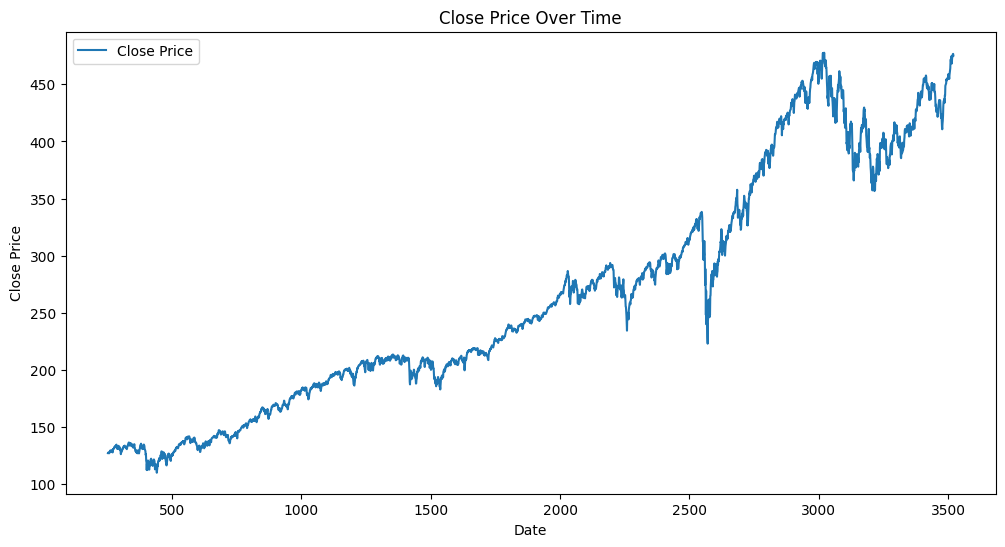

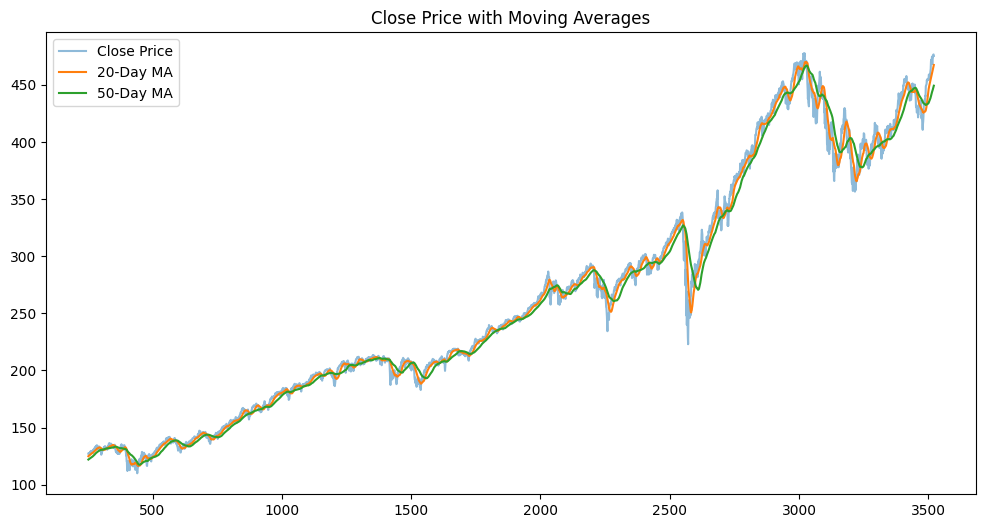

In [11]:
# Plot Close Price over time
plt.figure(figsize=(12, 6))
plt.plot(spy_data['Close'], label='Close Price')
plt.title("Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plot rolling averages
plt.figure(figsize=(12, 6))
spy_data['Close'].plot(label='Close Price', alpha=0.5)
spy_data['Short_MA'].plot(label='20-Day MA')
spy_data['Long_MA'].plot(label='50-Day MA')
plt.title("Close Price with Moving Averages")
plt.legend()
plt.show()


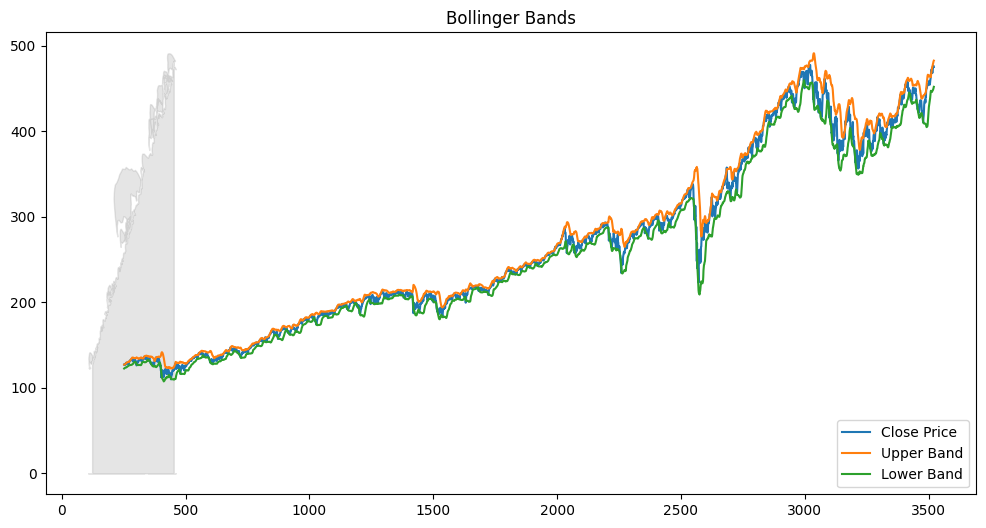

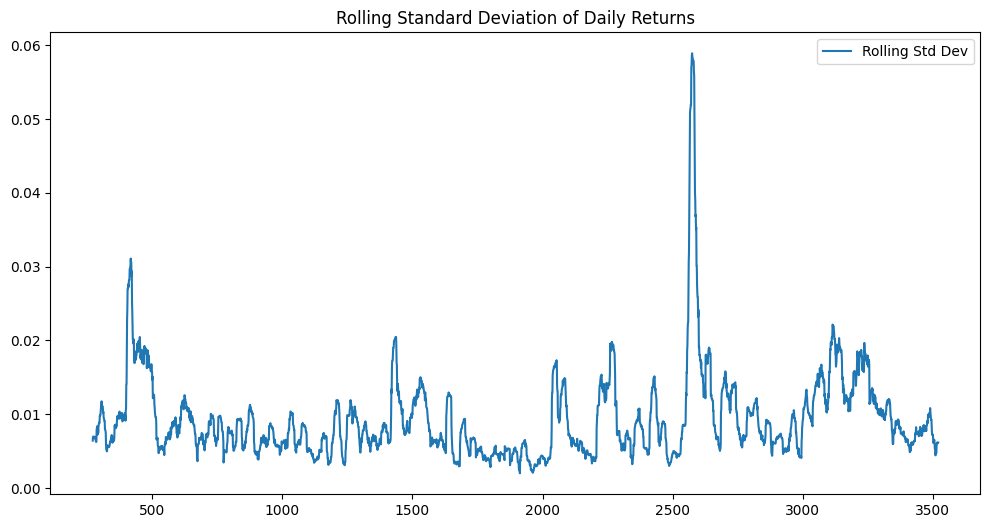

In [12]:
# Plot Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(spy_data['Close'], label='Close Price')
plt.plot(spy_data['Upper_Band'], label='Upper Band')
plt.plot( spy_data['Lower_Band'], label='Lower Band')
plt.fill_between( spy_data['Lower_Band'], spy_data['Upper_Band'], color='gray', alpha=0.2)
plt.title("Bollinger Bands")
plt.legend()
plt.show()

# Rolling standard deviation
spy_data['Rolling_Std'] = spy_data['Daily_Return'].rolling(window=20).std()
plt.figure(figsize=(12, 6))
plt.plot( spy_data['Rolling_Std'], label='Rolling Std Dev')
plt.title("Rolling Standard Deviation of Daily Returns")
plt.legend()
plt.show()


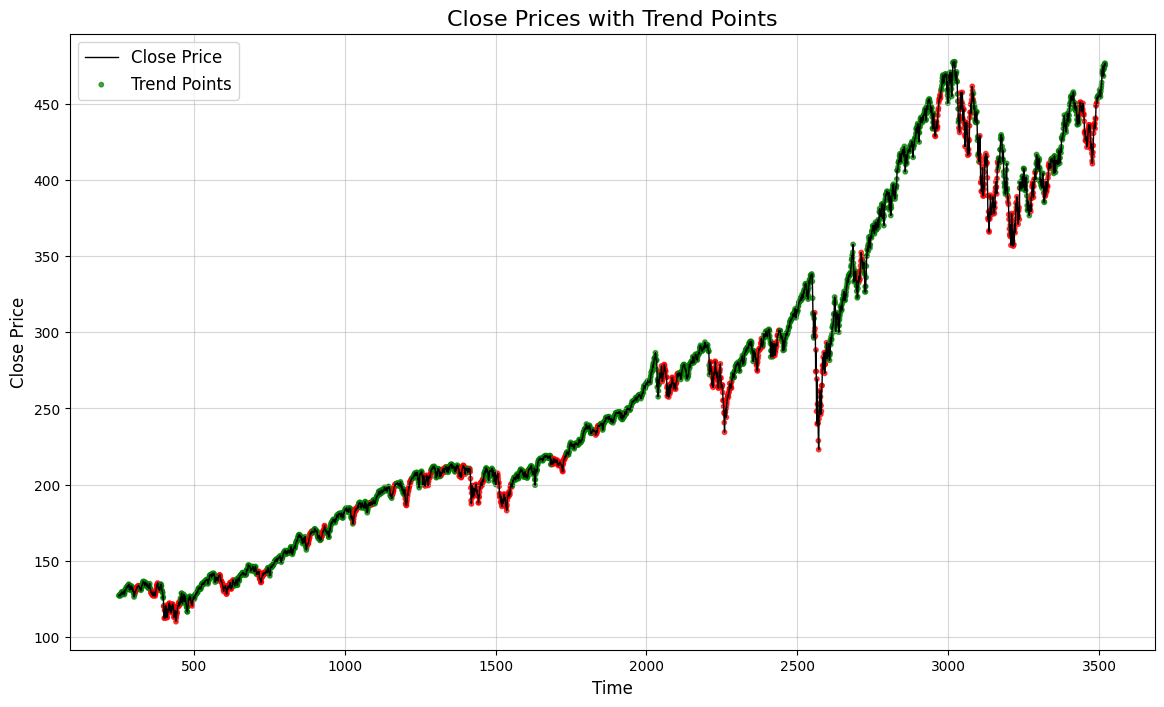

In [14]:
# Map trends to colors for better visualization
trend_colors = {
    'Uptrend': 'green',
    'Downtrend': 'red',
    'Neutral': 'blue'
}

# Assign colors to trends
spy_data['Trend_Color'] = spy_data['Trend_Encoded'].map({
    1: 'blue',  # Neutral
    2: 'green', # Uptrend
    0: 'red'    # Downtrend
})

# Plot Close prices
plt.figure(figsize=(14, 8))
plt.plot(spy_data.index, spy_data['Close'], label='Close Price', color='black', linewidth=1)

# Highlight trends
plt.scatter(spy_data.index, spy_data['Close'], c=spy_data['Trend_Color'], label='Trend Points', alpha=0.7, s=10)

# Add labels and legend
plt.title('Close Prices with Trend Points', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(['Close Price', 'Trend Points'], fontsize=12)
plt.grid(alpha=0.5)
plt.show()

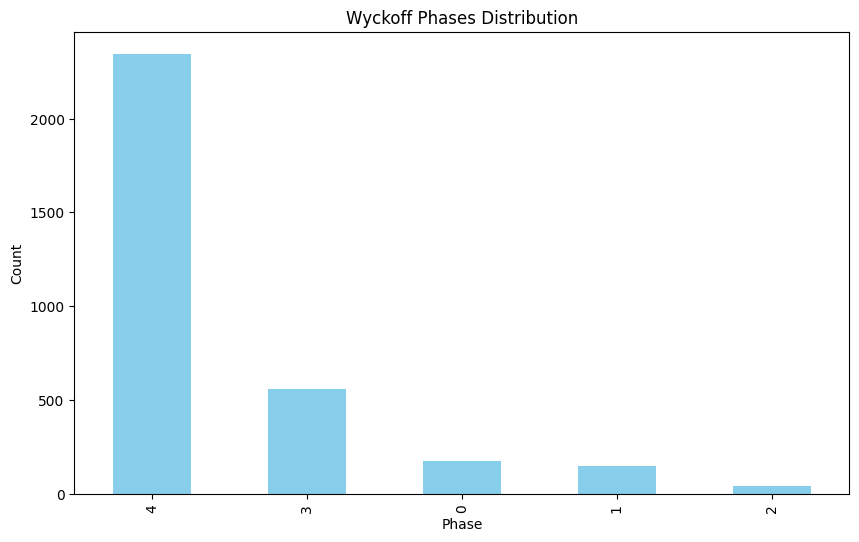

In [17]:
# Plot Wyckoff Phases
plt.figure(figsize=(10, 6))
spy_data['Wyckoff_Phase_Encoded'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Wyckoff Phases Distribution")
plt.xlabel("Phase")
plt.ylabel("Count")
plt.show()

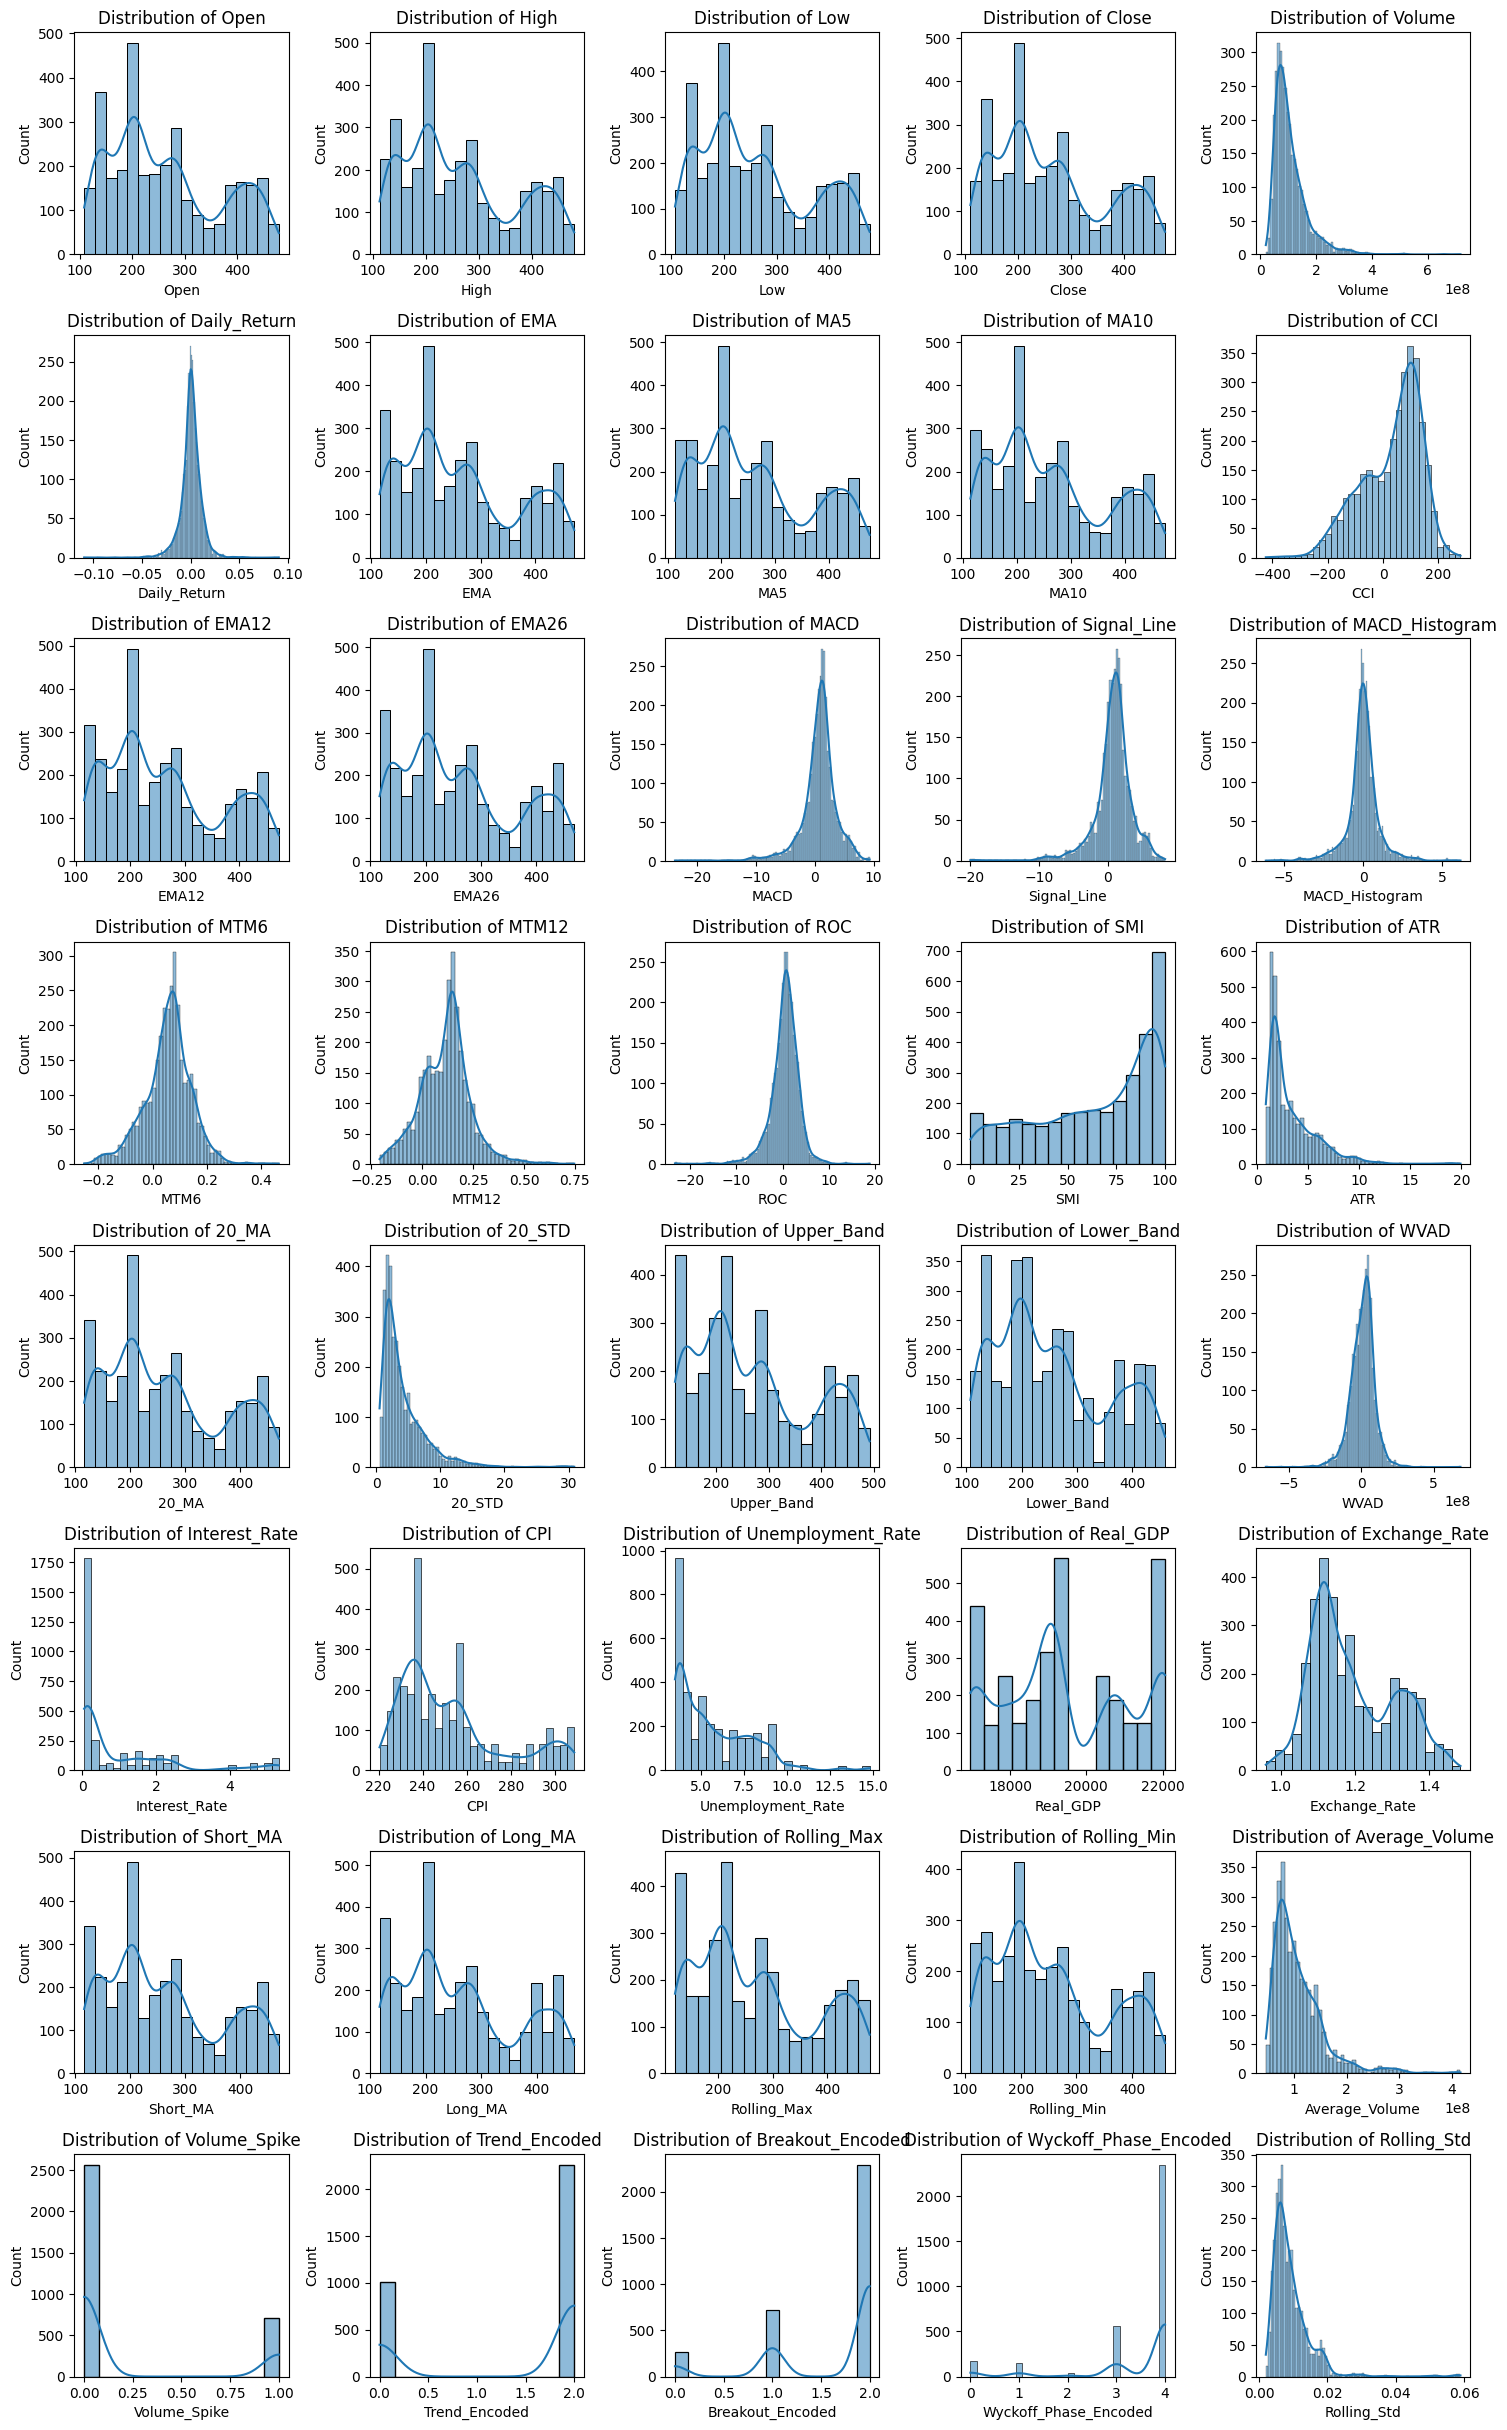

In [22]:
num_columns = spy_data.select_dtypes(include=['float64', 'int64']).columns
total_vars = len(num_columns)

cols = 5  
rows = (total_vars // cols) + 1  

plt.figure(figsize=(15, rows * 3))  
for i, col in enumerate(num_columns, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(spy_data[col], kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

# Model Implementation

For the model implementation, we explored a diverse range of predictive approaches to capture different aspects of stock market behavior. Specifically, we implemented a Long Short-Term Memory (LSTM) neural network, a Random Forest (RF), a Decision Tree (DT), and a Support Vector Machine (SVM)

## LSTM

In [119]:
def create_sequences_with_target(data, time_steps, target_column):

    sequences = []
    targets = []

    max_index = len(data) - time_steps
    for i in range(max_index):
        # Extract a sequence of `time_steps`
        sequence = data[i:i + time_steps]
        sequences.append(sequence)

        # Target is the `Close` (or target_column) for the next day (day 61)
        target = data[i + time_steps, target_column]
        targets.append(target)

    return np.array(sequences), np.array(targets)

# Create sequences with 5 time steps and separate target (Daily_Return is the last column)
time_steps = 5
target_column = 5 # Assuming 'Daily_Return' is the 6th column (index 5)

X, y = create_sequences_with_target(data, time_steps, target_column)

print("Shape of X:", X.shape)  # (num_samples, time_steps, num_features-1)
print("Shape of y:", y.shape)  # (num_samples,)

Shape of X: (3265, 5, 41)
Shape of y: (3265,)


In [120]:
# Define the split ratio
test_size = 0.2  # 20% for validation

# Split the data (X and y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)

print("Shape of X_train:", X_train.shape)  # Training features
print("Shape of X_val:", X_val.shape)      # Validation features
print("Shape of y_train:", y_train.shape)  # Training targets
print("Shape of y_val:", y_val.shape)      # Validation targets

Shape of X_train: (2612, 5, 41)
Shape of X_val: (653, 5, 41)
Shape of y_train: (2612,)
Shape of y_val: (653,)


### LSTM - Model Architecture 

This is our LSTM architecture, designed for the task of predicting daily returns. The model consists of a single LSTM layer with 32 units, followed by a dropout layer to prevent overfitting, and a dense output layer with a linear activation function for regression. The learning rate is set to 0.0047, as determined through hyperparameter tuning.

We experimented adding additional LSTM layers and increasing complexity, but we found that a single-layer architecture performed best, striking the right balance between simplicity and effectiveness. This final architecture reflects the tuned parameters that yielded the most reliable results in our tests.

In [121]:
def create_LSTM(input_shape, units=32, dropout_rate=0.0):
    
    model = Sequential()

    model.add(Input(shape=input_shape))

    # Bidirectional LSTM Layer
    model.add(LSTM(units, return_sequences=False))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # Dense output layer
    model.add(Dense(1, activation='linear'))  # Linear activation for regression tasks

    # Set a custom learning rate
    learning_rate = 0.0047  
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

### LSTM - Model Experimentation

### Output: Returns vs Prices

##### Prices

We initially focused on predicting the closing price for the next day but encountered several challenges:

Predicting prices with models like Random Forests or LSTMs can lead to misleading outcomes if the data is not handled carefully. One major challenge is that common error metrics, such as Mean Squared Error (MSE), disproportionately penalize larger errors. For example:

- An error of $2 on a $100 stock (2%) will be treated the same as an error of $2 on a $10 stock (20%).
- This introduces a bias in the model’s evaluation, prioritizing accuracy on higher prices while potentially ignoring the relative magnitude of the error.

To mitigate this, we normalized the prices and features in an attempt to remove scale dependency. However, this led to another issue: the model started predicting prices with what was essentially a one-day delay. This occurs because prices are not highly volatile, and their values are closely correlated to the previous day’s price. As a result, while the predictions may appear visually accurate in the graph below, they are not informative for decision-making. 

![Description of the image](fotos/prices2.png)


Another significant limitation of predicting prices is their non-stationary nature, meaning their statistical properties, such as mean and variance, change over time. This characteristic makes it difficult for models to generalize effectively, particularly for long-term predictions. A model trained on non-stationary data may perform well in the short term but fail to adapt to other datasets or unseen future data, limiting its robustness and reliability.

##### Returns

So, our solution was to change our output to returns. Returns are stationary, meaning their statistical properties like mean and variance remain stable over time, which helps the model generalize better and perform well on future unseen data. Additionally, with returns, the penalties for prediction errors are consistent, regardless of the price scale. This ensures fairness in model evaluation and avoids biases toward higher-priced stocks.

Moreover, the issue of the model simply predicting based on the previous day is less concerning with returns, as they are more volatile and dynamic compared to prices. This makes it harder for the model to rely solely on autocorrelation, forcing it to learn actual patterns. Returns also provide clearer insights into performance, making it easier to evaluate whether the model is predicting well.

![Description of the image](fotos/returns.png)

## Normalization

#### MinMax

We initially explored normalizing the features for our LSTM model since neural networks generally perform better when input features are scaled to a consistent range. Our first approach was to use MinMax Scaling, as it transforms features to a fixed range (e.g., [0, 1]).

However, MinMax Scaling introduced several issues:

1. Loss of Context:

- For instance, if the close prices are [5, 10, 11], after scaling, they become [0, 0.5, 1]. This transformation distorts the relative differences between values, especially for features where these differences are crucial for capturing patterns (e.g., comparing Moving Averages with Close prices).

2. Generalizability:

- MinMax Scaling relies on the minimum and maximum values in the dataset. If prices in the future exceed the maximum seen during training, the scaled values will exceed the expected range, potentially causing the model to perform poorly or unpredictably on new data.

#### Z-Score

After observing the limitations of MinMax scaling, we turned to Z-Score normalization as a potential solution. Z-Score normalization scales each feature by subtracting its mean and dividing by its standard deviation, resulting in features with a mean of 0 and a standard deviation of 1. This approach standardizes values relative to their distribution, preserving the inherent differences.

However, despite its theoretical advantages, Z-Score normalization introduces its own set of challenges:

1. Loss of Relativeness Between Features:

Many features in financial analysis are inherently related to one another. For example, moving averages (e.g., MA5, MA10) are often compared with the current close price to determine trends. When each feature is independently normalized using Z-Score, the relative relationships between these features are distorted. This loss of relativeness undermines the patterns these features are meant to capture, reducing their interpretability and effectiveness.

2. Scaling Features Together Still Has Issues:

To address the relativeness problem, we considered scaling related features (e.g., close price, moving averages, volatility measures) together by applying the same Z-Score transformation. While this approach retains relative relationships within the group, it introduces another issue for features with different distributions.

- Features with larger standard deviations within the group will have a more significant influence on the scaling process compared to features with smaller standard deviations.
- For example, if the Close price has a high standard deviation while EMA has a smaller one, the scaling will disproportionately adjust the smaller deviations, potentially downplaying its significance.

We can see in this graph our model with standardized features having difficulties finding patterns:

![Description of the image](fotos/zscore.png)

#### Final Decision: Avoiding Normalization

Given these challenges, we ultimately decided not to normalize or standardize any of our features. By keeping features in their original scales:

We preserve the inherent relationships between features like price, moving averages, and volatility indicators.
Thresholds for features like the CCI remain meaningful and interpretable.
The model can work directly with the raw data, leveraging the natural relationships without introducing distortions through normalization.

### Unidirectional vs Bidirectional (LSTM)

We compared the performance of a unidirectional LSTM against a bidirectional LSTM for our task. While the unidirectional model provided slightly better results, the difference in performance was not significant. However, given the minimal increase in loss and the additional complexity of the bidirectional model, we opted to use the unidirectional LSTM.

- Uni-LSTM vs Bi-LSTM:

![Description of the image](fotos/UniLSTM.png) ![Description of the image](fotos/BiLSTM.png)

### Time Steps

We initially used a time step of 20, which represented approximately one month of trading data. However, to explore the impact of different time frames on model performance, we tested various time step values (2, 5, 10, 20, 40). Through this experimentation, we found that a time step of 5 was the ideal choice. With this shorter timeframe, we observed a decrease in loss, accompanied by a significant improvement in both cumulative return and directional accuracy. This adjustment allowed the model to capture short-term market dynamics more effectively, enhancing its predictive performance.

- Time Steps = 20: 

![Description of the image](fotos/20timestep.png)

- Time Steps = 5:

![Description of the image](fotos/5timestep.png)


## LSTM Hyperband Tuning

To optimize our LSTM model, we conducted hyperparameter tuning using Keras Tuner's Hyperband. The key parameters tuned were:

- Number of units in the LSTM layer: Tested values between 32 and 256, with increments of 32.
- Dropout rate: Explored between 0.0 and 0.3 in increments of 0.1 to prevent overfitting.
- Learning rate: Tuned on a logarithmic scale between 0.0001 and 0.01 for the Adam optimizer.

The Hyperband algorithm efficiently searched for the best configuration over a maximum of 200 epochs, with early stopping employed to avoid overfitting. After the search, the best hyperparameters were extracted and used in the final model.

In [122]:
# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2]) 

def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=input_shape))
    
    # LSTM layer with tunable units
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        return_sequences=False
    ))
    
    # Dropout layer with tunable rate
    model.add(tf.keras.layers.Dropout(hp.Float('dropout', min_value=0.0, max_value=0.3, step=0.1)))
    
    # Output layer
    model.add(Dense(1, activation='linear'))
    
    # Compile the model with tunable learning rate (log scale)
    optimizer = Adam(learning_rate=hp.Float(
        'learning_rate', 
        min_value=0.0001, 
        max_value=0.01, 
        sampling='log'
    ))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model


In [123]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',  # Optimize for validation loss
    max_epochs=200,         # Maximum number of epochs
    factor=3,              # Factor by which the number of epochs is reduced for each bracket
    directory='hyperband_tuning_lstm',  # Directory to save tuning results
    project_name='LSTM_tuning2'     # Project name for organizing tuning results
)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best number of units: {best_hps.get('units')}")
print(f"Best dropout rate: {best_hps.get('dropout')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

Reloading Tuner from hyperband_tuning_lstm\LSTM_tuning2\tuner0.json
Best number of units: 32
Best dropout rate: 0.0
Best learning rate: 0.004709204876882726


### Importance of identifying Market Behaviour

After incorporating additional features derived from market trends and behavior, such as trend identification (Trend), breakout levels (Rolling_Max and Rolling_Min), volume spikes (Volume_Spike), and Wyckoff phases, our models demonstrated a significant improvement in performance. 

This enhancement was primarily attributed to an increase in directional accuracy, as these features provided a deeper understanding of market dynamics. By capturing key patterns in market behavior, such as uptrends, downtrends, and breakout movements, the models were better equipped to predict the direction of daily returns effectively, resulting in more informed and accurate predictions.

without Market condition features vs with Market condition features

![Description of the image](fotos/beforemarket.png) ![Description of the image](fotos/aftermarket.png)

### MSE vs MAE vs Custom Loss with SD Penalty



After completing the hyperparameter tuning process, we identified a significant issue with the model’s predictions. The standard deviation (SD) of the predicted returns was considerably smaller than the actual returns. This issue arose because the model, in an effort to minimize the Mean Squared Error (MSE), tended to produce overly smooth predictions, failing to capture the full variability of the actual returns.

Using MSE:


![Description of the image](fotos/mse3.png)

Since our ultimate goal is to predict returns for 428 companies, it is critical for the model to closely approximate the actual returns, including their volatility.

To address this, we initially replaced the MSE loss with the Mean Absolute Error (MAE). MAE is less sensitive to large errors, allowing the model to make bolder predictions without being overly penalized. While this change reduced the gap between the predicted and actual standard deviations, the difference was still substantial.

Using MAE:

![Description of the image](fotos/mae.png)

To further tackle this issue, we implemented a custom loss function. This loss function combines:

- MSE: To ensure accuracy in predicting returns.
- SD Penalty: A penalty term that increases the loss when the standard deviation of the predictions deviates significantly from the standard deviation of the actual returns.

This custom loss function allows the model to not only minimize the prediction error but also align the volatility of its predictions with the actual market returns. By encouraging the model to match the variability in the data, we aim to make the predictions more realistic and usable for portfolio analysis and financial decision-making.

In [124]:
def custom_loss_with_sd_penalty(y_true, y_pred):
    # Mean Squared Error
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Standard deviation of actual and predicted values
    actual_sd = tf.math.reduce_std(y_true)
    predicted_sd = tf.math.reduce_std(y_pred)
    
    # Penalty for difference in standard deviation
    sd_penalty = tf.square(actual_sd - predicted_sd)
    
    # Combine MSE and SD penalty
    return mse + 0.5 * sd_penalty  # Adjust the weight (e.g., 0.1) as needed

Using custom loss function:

![Description of the image](fotos/customloss6.png)

While this approach led to an improvement in the alignment of standard deviations, it resulted in higher Mean Squared Error (MSE) and Mean Absolute Error (MAE). Given that the primary goal of our model is to minimize these core metrics, **we decided keep MSE as our main loss function for the final model.**

## Model Training and Predictions

Epoch 1/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1202 - mae: 0.2819 - val_loss: 0.0423 - val_mae: 0.1603
Epoch 2/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0394 - mae: 0.1509 - val_loss: 0.0236 - val_mae: 0.1211
Epoch 3/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0252 - mae: 0.1204 - val_loss: 0.0136 - val_mae: 0.0871
Epoch 4/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0150 - mae: 0.0890 - val_loss: 0.0083 - val_mae: 0.0661
Epoch 5/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - mae: 0.0696 - val_loss: 0.0055 - val_mae: 0.0520
Epoch 6/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - mae: 0.0565 - val_loss: 0.0039 - val_mae: 0.0428
Epoch 7/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - mae: 0.0473 - val_loss: 0.0030 - val_mae: 0.0372
Epoch 8/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mae: 0.0408 - val_loss: 0.0024 - val_mae: 0.0330
Epoch 9/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.00

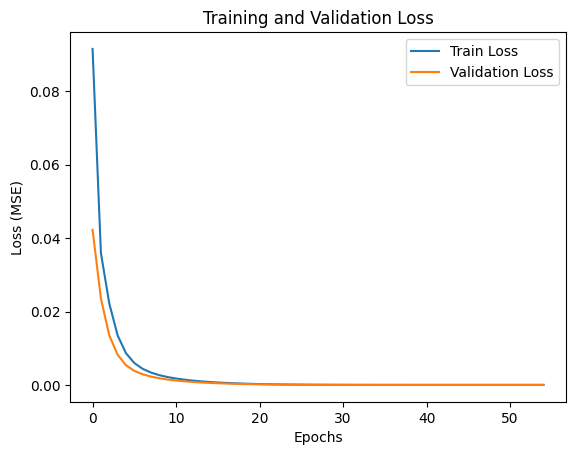

In [125]:
random.seed(42)
# Set random seed for NumPy
np.random.seed(42)
# Set random seed for TensorFlow
tf.random.set_seed(42)

# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_features)

# Create the model
model = create_LSTM(input_shape=input_shape)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,  # Adjust as needed
    batch_size=128,  # Adjust as needed
    verbose=1,  # 1 shows progress after each epoch
    callbacks=[early_stopping]  # Include early stopping
)

# Evaluate the model
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss (MSE): {val_loss}")
print(f"Validation MAE: {val_mae}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [126]:
# Predict returns for the validation set
y_pred = model.predict(X_val).flatten()  # Predicted returns (flattened to 1D)
y_true = y_val  # True returns from validation set

# Initialize variables
position = 0  # Current position: 1 = in the market, 0 = out of the market
cumulative_return = 1  # Starting with 1 (100% initial capital)
strategy_returns = []
buy_hold_return = 1  # To store daily returns from the strategy

# Iterate over the predicted and true returns
for i in range (0,len(y_pred)):
    pred_return = y_pred[i]
    true_return = y_true[i]
    if pred_return > 0 and position == 0:
        # Buy if predicted return is positive and currently out of the market
        position = 1
    elif pred_return < 0 and position == 1:
        # Sell if predicted return is negative and currently in the market
        position = 0
    
    # Calculate daily return based on true return if in the market
    daily_return = true_return if position == 1 else 0
    #daily_return = true_return if position == 1 else 0
    strategy_returns.append(daily_return)

    # Update cumulative return
    cumulative_return *= (1 + daily_return)
    buy_hold_return *= (1 + true_return)

# Print cumulative return
print(f"Cumulative Return: {cumulative_return - 1:.2%}")  # As a percentage
print(f"Buy-and-Hold Return: {buy_hold_return - 1:.2%}")
print("")

# Directional Accuracy
directional_accuracy = np.mean((y_pred > 0) == (y_val > 0))
print(f"Directional Accuracy: {directional_accuracy:.2%}")
print(f"Mean of Predicted Returns: {np.mean(y_pred)}")
print(f"Mean of Actual Returns: {np.mean(y_val)}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Cumulative Return: 44.16%
Buy-and-Hold Return: 13.42%

Directional Accuracy: 55.28%
Mean of Predicted Returns: 0.00040236502536572516
Mean of Actual Returns: 0.00025787571359533654


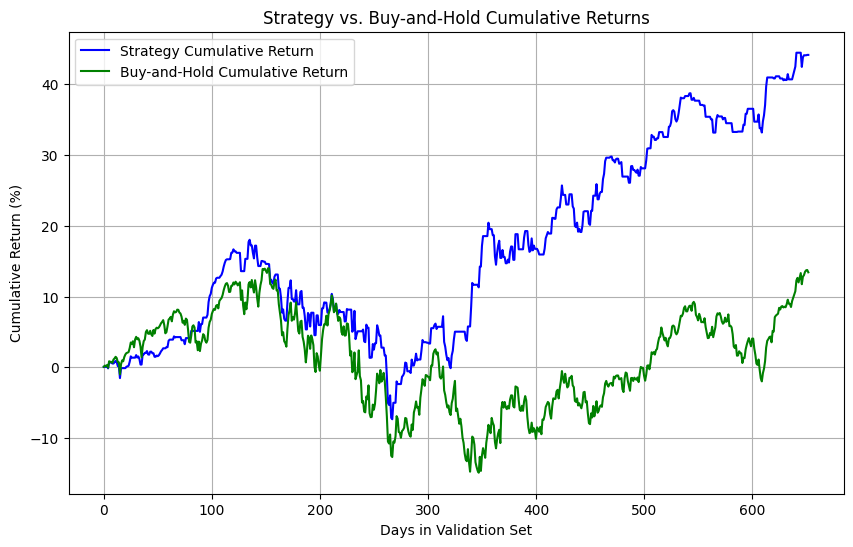

In [127]:
# Calculate cumulative returns for plotting
strategy_cumulative = (np.cumprod(1 + np.array(strategy_returns)) - 1) * 100
true_cumulative = (np.cumprod(1 + y_true) - 1) * 100

plt.figure(figsize=(10, 6))
plt.plot(strategy_cumulative, label="Strategy Cumulative Return", color='blue')
plt.plot(true_cumulative, label="Buy-and-Hold Cumulative Return", color='green')
plt.xlabel("Days in Validation Set")
plt.ylabel("Cumulative Return (%)")
plt.title("Strategy vs. Buy-and-Hold Cumulative Returns")
plt.legend()
plt.grid()
plt.show()

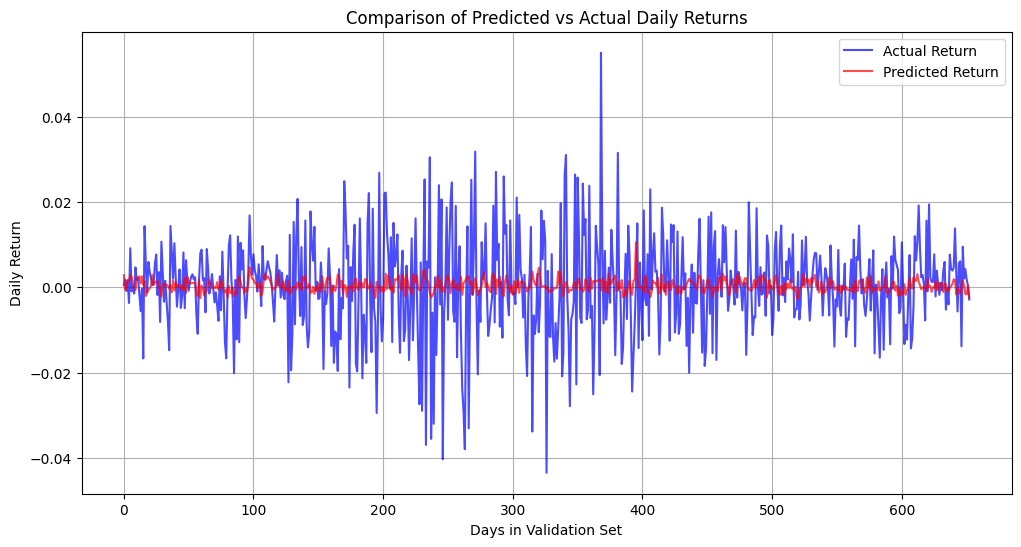

In [128]:
import matplotlib.pyplot as plt

# Plot predicted vs. actual returns
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual Return', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Return', color='red', alpha=0.7)
plt.xlabel("Days in Validation Set")
plt.ylabel("Daily Return")
plt.title("Comparison of Predicted vs Actual Daily Returns")
plt.legend()
plt.grid()
plt.show()


## Machine Learning models: RF, DT, SVM

In [129]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

### Random Forest 

In [150]:
# Initialize the Random Forest Regressor with the tuned parameters
rf_regressor = RandomForestRegressor(
    n_estimators=25,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42  # Set random_state for reproducibility
)

# Fit the model on the training data
rf_regressor.fit(X_train, y_train)

# Predict on the validation set
y_pred_rf = rf_regressor.predict(X_val)

# Calculate metrics
mse_rf = mean_squared_error(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
correlation_rf = np.corrcoef(y_val, y_pred_rf)[0, 1]  # Correlation coefficient

print(f"Random Forest - Mean Squared Error (MSE): {mse_rf:.6f}")
print(f"Random Forest - Mean Absolute Error (MAE): {mae_rf:.6f}")
print(f"Random Forest - Correlation Coefficient: {correlation_rf:.2f}")


Random Forest - Mean Squared Error (MSE): 0.000202
Random Forest - Mean Absolute Error (MAE): 0.010165
Random Forest - Correlation Coefficient: 0.02


In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [25, 50, 100],          # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],        # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],        # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],          # Minimum samples required at a leaf node
}

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use MSE as the evaluation metric
    cv=5,                              # 5-fold cross-validation
    verbose=2,
    n_jobs=-1                          # Use all available cores
)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found by GridSearchCV:", best_params)

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
y_pred_rf = best_model.predict(X_val)

# Calculate metrics
mse_rf = mean_squared_error(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
correlation_rf = np.corrcoef(y_val, y_pred_rf)[0, 1]

print(f"Optimized Random Forest - Mean Squared Error (MSE): {mse_rf:.6f}")
print(f"Optimized Random Forest - Mean Absolute Error (MAE): {mae_rf:.6f}")
print(f"Optimized Random Forest - Correlation Coefficient: {correlation_rf:.2f}")

'\n\n# Define the parameter grid\nparam_grid = {\n    \'n_estimators\': [25, 50, 100],          # Number of trees in the forest\n    \'max_depth\': [None, 10, 20, 30],        # Maximum depth of each tree\n    \'min_samples_split\': [2, 5, 10],        # Minimum samples required to split a node\n    \'min_samples_leaf\': [1, 2, 4],          # Minimum samples required at a leaf node\n}\n\n# Initialize the Random Forest Regressor\nrf_regressor = RandomForestRegressor(random_state=42)\n\n# Set up GridSearchCV\ngrid_search = GridSearchCV(\n    estimator=rf_regressor,\n    param_grid=param_grid,\n    scoring=\'neg_mean_squared_error\',  # Use MSE as the evaluation metric\n    cv=5,                              # 5-fold cross-validation\n    verbose=2,\n    n_jobs=-1                          # Use all available cores\n)\n\n# Fit the model to the training data\ngrid_search.fit(X_train, y_train)\n\n# Get the best parameters\nbest_params = grid_search.best_params_\nprint("Best parameters found by

### Decision Tree 

In [156]:
# Initialize the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Define the parameter grid
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],        # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],        # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],          # Minimum samples required at a leaf node
}

# Set up GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(
    estimator=dt_regressor,
    param_grid=param_grid_dt,
    scoring='neg_mean_squared_error',  # Use MSE as the evaluation metric
    cv=5,                              # 5-fold cross-validation
    verbose=2,
    n_jobs=-1                          # Use all available cores
)

# Fit the model to the training data
grid_search_dt.fit(X_train, y_train)

# Get the best parameters
best_params_dt = grid_search_dt.best_params_
print("Best parameters found by GridSearchCV for Decision Tree:", best_params_dt)

# Evaluate the best model on the validation set
best_model_dt = grid_search_dt.best_estimator_
y_pred_dt = best_model_dt.predict(X_val)

# Calculate metrics
mse_dt = mean_squared_error(y_val, y_pred_dt)
mae_dt = mean_absolute_error(y_val, y_pred_dt)
correlation_dt = np.corrcoef(y_val, y_pred_dt)[0, 1]

print(f"Optimized Decision Tree - Mean Squared Error (MSE): {mse_dt:.6f}")
print(f"Optimized Decision Tree - Mean Absolute Error (MAE): {mae_dt:.6f}")
print(f"Optimized Decision Tree - Correlation Coefficient: {correlation_dt:.2f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found by GridSearchCV for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Optimized Decision Tree - Mean Squared Error (MSE): 0.000392
Optimized Decision Tree - Mean Absolute Error (MAE): 0.012875
Optimized Decision Tree - Correlation Coefficient: -0.05


### SVM

In [ ]:
# Initialize the Support Vector Regressor
svr_regressor = SVR()

# Define the parameter grid
param_grid_svr = {
    'kernel': ['linear', 'rbf', 'poly'],   # Kernel types
    'C': [0.1, 1, 10],                    # Regularization parameter
    'gamma': ['scale', 'auto'],           # Kernel coefficient
    'epsilon': [0.01, 0.1, 0.2],          # Epsilon in the epsilon-SVR
}

# Set up GridSearchCV for SVM
grid_search_svr = GridSearchCV(
    estimator=svr_regressor,
    param_grid=param_grid_svr,
    scoring='neg_mean_squared_error',  # Use MSE as the evaluation metric
    cv=5,                              # 5-fold cross-validation
    verbose=2,
    n_jobs=-1                          # Use all available cores
)

# Fit the model to the training data
grid_search_svr.fit(X_train, y_train)

# Get the best parameters
best_params_svr = grid_search_svr.best_params_
print("Best parameters found by GridSearchCV for SVM:", best_params_svr)

# Evaluate the best model on the validation set
best_model_svr = grid_search_svr.best_estimator_
y_pred_svr = best_model_svr.predict(X_val)

# Calculate metrics
mse_svr = mean_squared_error(y_val, y_pred_svr)
mae_svr = mean_absolute_error(y_val, y_pred_svr)
correlation_svr = np.corrcoef(y_val, y_pred_svr)[0, 1]

print(f"Optimized SVM - Mean Squared Error (MSE): {mse_svr:.6f}")
print(f"Optimized SVM - Mean Absolute Error (MAE): {mae_svr:.6f}")
print(f"Optimized SVM - Correlation Coefficient: {correlation_svr:.2f}")

## References

Books:

- Jacinta Chan (Year). Automation of Trading Machines for Traders.


- Rolf Schlotmann and Moritz Czubatinski (Year). Technical Analysis Masterclass.


- Rubén Villahermosa (Year). The Wyckoff Methodology in Depth.


Articles:

- Lim, M., & Zohren, S. (2021). Time-Series Forecasting with Deep Learning: A Survey.
Highlighted the integration of deep learning models in financial forecasting, providing a broad perspective on state-of-the-art methodologies.

- Wei Bao, Jun Yue, and Yulei Rao. A deep learning framework for financial
time series using stacked autoencoders and long-short term memory. PloS one,
12(7):e0180944, 2017

- Jigar Patel, Sahil Shah, Priyank Thakkar, and Ketan Kotecha. Predicting stock
and stock price index movement using trend deterministic data preparation and
machine learning techniques. Expert systems with applications, 42(1):259–268,
2015

- Chi-Ming Lin and Mitsuo Gen. Multi-criteria human resource allocation for solving multistage combinatorial optimization problems using multiobjective hybrid
genetic algorithm. Expert Systems with Applications, 34(4):2480–2490, 2008.

- Brockwell, P. J., & Davis, R. A. (2002). Introduction to Time Series and Forecasting (2nd ed.). Springer.
Served as a foundational text for understanding time series methods and their applications in financial forecasting.

- Glasserman, P. (2003). Monte Carlo Methods in Financial Engineering. Springer.
Provided a detailed exploration of Monte Carlo methods in finance, enhancing risk management and pricing models.